In [1838]:
#Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import r2_score

# Ignore the warnings
import warnings
warnings.filterwarnings('ignore')

In [1839]:
# Import data from CSV

day=pd.read_csv('day.csv')
day.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [1840]:
day.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [1841]:
# Number of rows and columns in the dataset

day.shape

(730, 16)

In [1842]:
day.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


In [1843]:
# Drop duplicate rows from the dataset

day.drop_duplicates(inplace=True)

In [1844]:
day.shape

(730, 16)

No rows were found to be duplicate. It is evident from the total number of rows before and after performing drop_duplicates. Also, since the data spans for 2 years of data, there are a total of 365x2 = 730 rows.

In [1845]:
# Drop all rows will NA values
day.dropna(axis=0, how='all', inplace=True)

In [1846]:
# Verifying the sum count of casual and registered users

day[ (day['casual'] + day['registered']) != day['cnt']]

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt


Since, the variable `cnt` accounts for both `casual` and `registered` users, we can continue to drop these columns.

In [1847]:
# Drop columns casual and registered

day.drop(['casual', 'registered'], axis=1, inplace=True)

In [1848]:
df=day[ (day['workingday'] == 0) & (day['holiday'] == 0) ]
df['weekday'].value_counts()

0    105
6    105
Name: weekday, dtype: int64

In [1849]:
def weekend_indicator(x):
    if (x.workingday == 0) & (x.holiday == 0):
        return 1
    else:
        return 0

day['weekend'] = day.apply(weekend_indicator, axis=1)

In [1850]:
day[day['weekend'] == 1].shape

(210, 15)

In [1851]:
# Drop weekday and workingday

day.drop(['weekday','workingday'], axis=1, inplace=True)

In [1852]:
# Drop instant and dtedate

day.drop(['instant', 'dteday'], axis=1, inplace=True)

### Convert yr numbers to labels

In [1853]:
day['yr'].replace({
    0: '2018',
    1: '2019'
}, inplace=True)

### Converting categorical variable to feature variables

In [1854]:
# Checking unique seasons

day['season'].unique()

array([1, 2, 3, 4])

In [1855]:
# Replace season values with the season name

day['season'].replace({
    1:'spring', 
    2:'summer', 
    3:'fall', 
    4:'winter'
}, inplace=True)

### Analysing the `weathersit` variable across 2018 and 2019

In [1856]:
# Checking unique values of weathersit

day['weathersit'].unique()

array([2, 1, 3])

In [1857]:
# Replace numbers with labels

day['weathersit'].replace({
    1:'clear_partlyCloudy', 
    2:'mist_cloudy', 
    3:'lightRain_snow'
}, inplace=True)

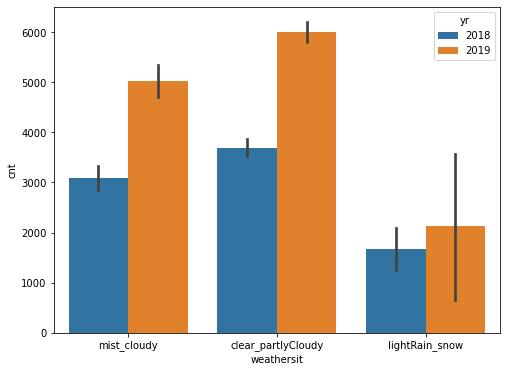

In [1858]:
plt.figure(figsize=(8,6))
sns.barplot(x=day['weathersit'], y=day['cnt'], hue=day['yr'])
plt.show()

### Analysing the `season` variable across 2018 and 2019

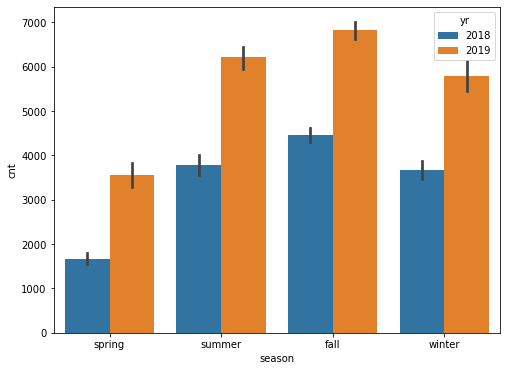

In [1859]:
plt.figure(figsize=(8,6))
sns.barplot(x=day['season'], y=day['cnt'], hue=day['yr'])
plt.show()

### Analysing `mnth` variable across 2018 and 2019

In [1860]:
# Checking unique values of mnth

day['mnth'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [1861]:
# Replace numbers with labels

day['mnth'].replace({
    1:'Jan', 
    2:'Feb', 
    3:'Mar',
    4:'Apr',
    5:'May',
    6:'Jun',
    7:'Jul',
    8:'Aug',
    9:'Sep',
    10:'Oct',
    11:'Nov',
    12:'Dec'
}, inplace=True)

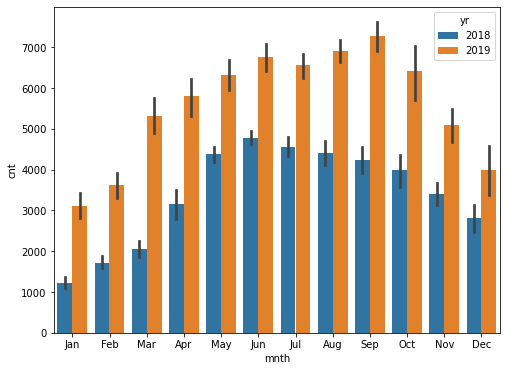

In [1862]:
plt.figure(figsize=(8,6))
sns.barplot(x=day['mnth'], y=day['cnt'], hue=day['yr'])
plt.show()

From the above two plots, we can see that `mnth` is a more granular level data than `season`. We can keep the season variable and drop mnth variable as keeping mnths will introduce 12 new independent features to the model.

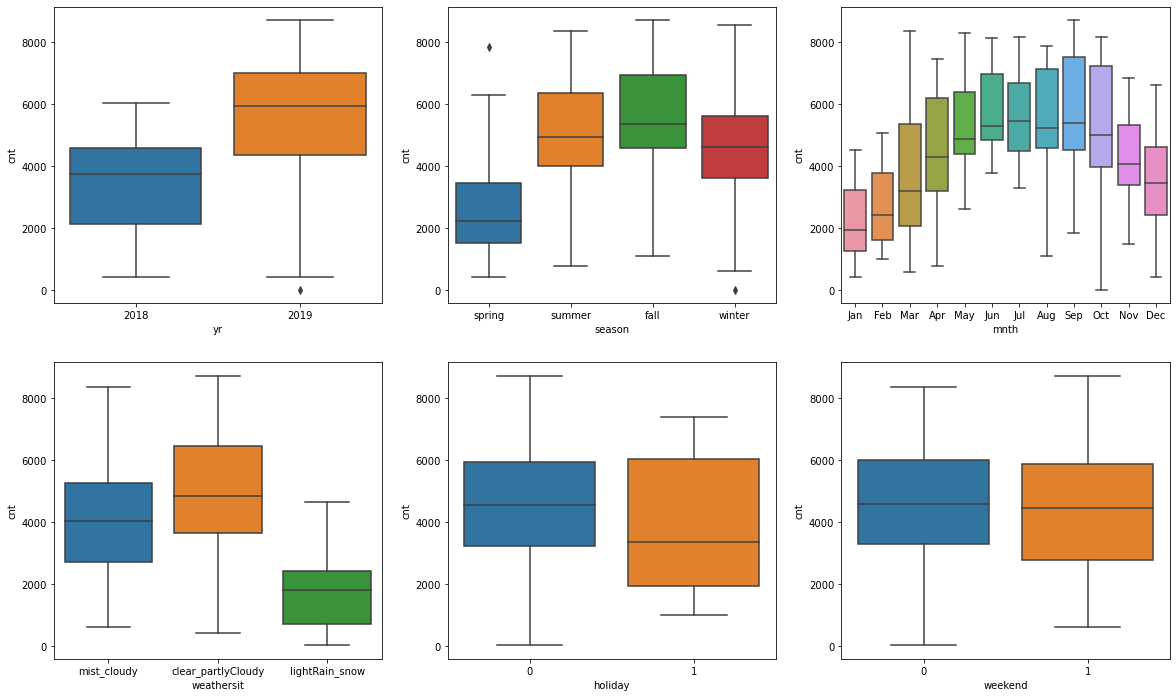

In [1863]:
# visualise the categorical variables

plt.figure(figsize=(20,12))
plt.subplot(2, 3, 1)
sns.boxplot(x='yr', y='cnt', data=day)

plt.subplot(2, 3, 2)
sns.boxplot(x='season', y='cnt', data=day)

plt.subplot(2, 3, 3)
sns.boxplot(x='mnth', y='cnt', data=day)

plt.subplot(2, 3, 4)
sns.boxplot(x='weathersit', y='cnt', data=day)

plt.subplot(2, 3, 5)
sns.boxplot(x='holiday', y='cnt', data=day)

plt.subplot(2, 3, 6)
sns.boxplot(x='weekend', y='cnt', data=day)
plt.show()

### Deriving Wind chill factor

$WCI=(10\sqrt v - v + 10.5).(33-T)$

v - Wind speed, 

T - Temperature

In [1864]:
def wind_chill_factor(x):
    return (10 * (x.windspeed)**(1/2) - x.windspeed + 10.5) * (33 - x.temp)

day['wind_chill'] = day.apply(wind_chill_factor, axis=1)

### Deriving Heat Index (HI)

$HI = c_1+c_2T+c_3R+c_4TR+c_5T^2+c_6R^2+c_7T^2R+c_8TR^2+c_9T^2R^2$

HI - Heat Index (in Celcius),

$c_1 .. c_9$ - coefficients,

R - Relative Humidity,

T - Temperature (in Celcius)

In [1865]:
def calculate_heat_index(x):
    # Source: https://en.wikipedia.org/wiki/Heat_index
    c1 = -8.78469475556
    c2 = 1.61139411
    c3 = 2.33854883889
    c4 = -0.14611605
    c5 = -0.012308094
    c6 = -0.0164248277778
    c7 = 0.002211732
    c8 = 0.00072546
    c9 = -0.000003582
    
    t = x.temp
    r = x.hum
    
    return c1 + (c2 * t) + (c3 * r) + (c4 * t * r) + (c5 * t * t) + (c6 * r * r) + (c7 * t * t * r) + (c8 * t * r * r) + (c9 * t * t * r * r)
    
    
day['heat_index']=day.apply(calculate_heat_index, axis=1)

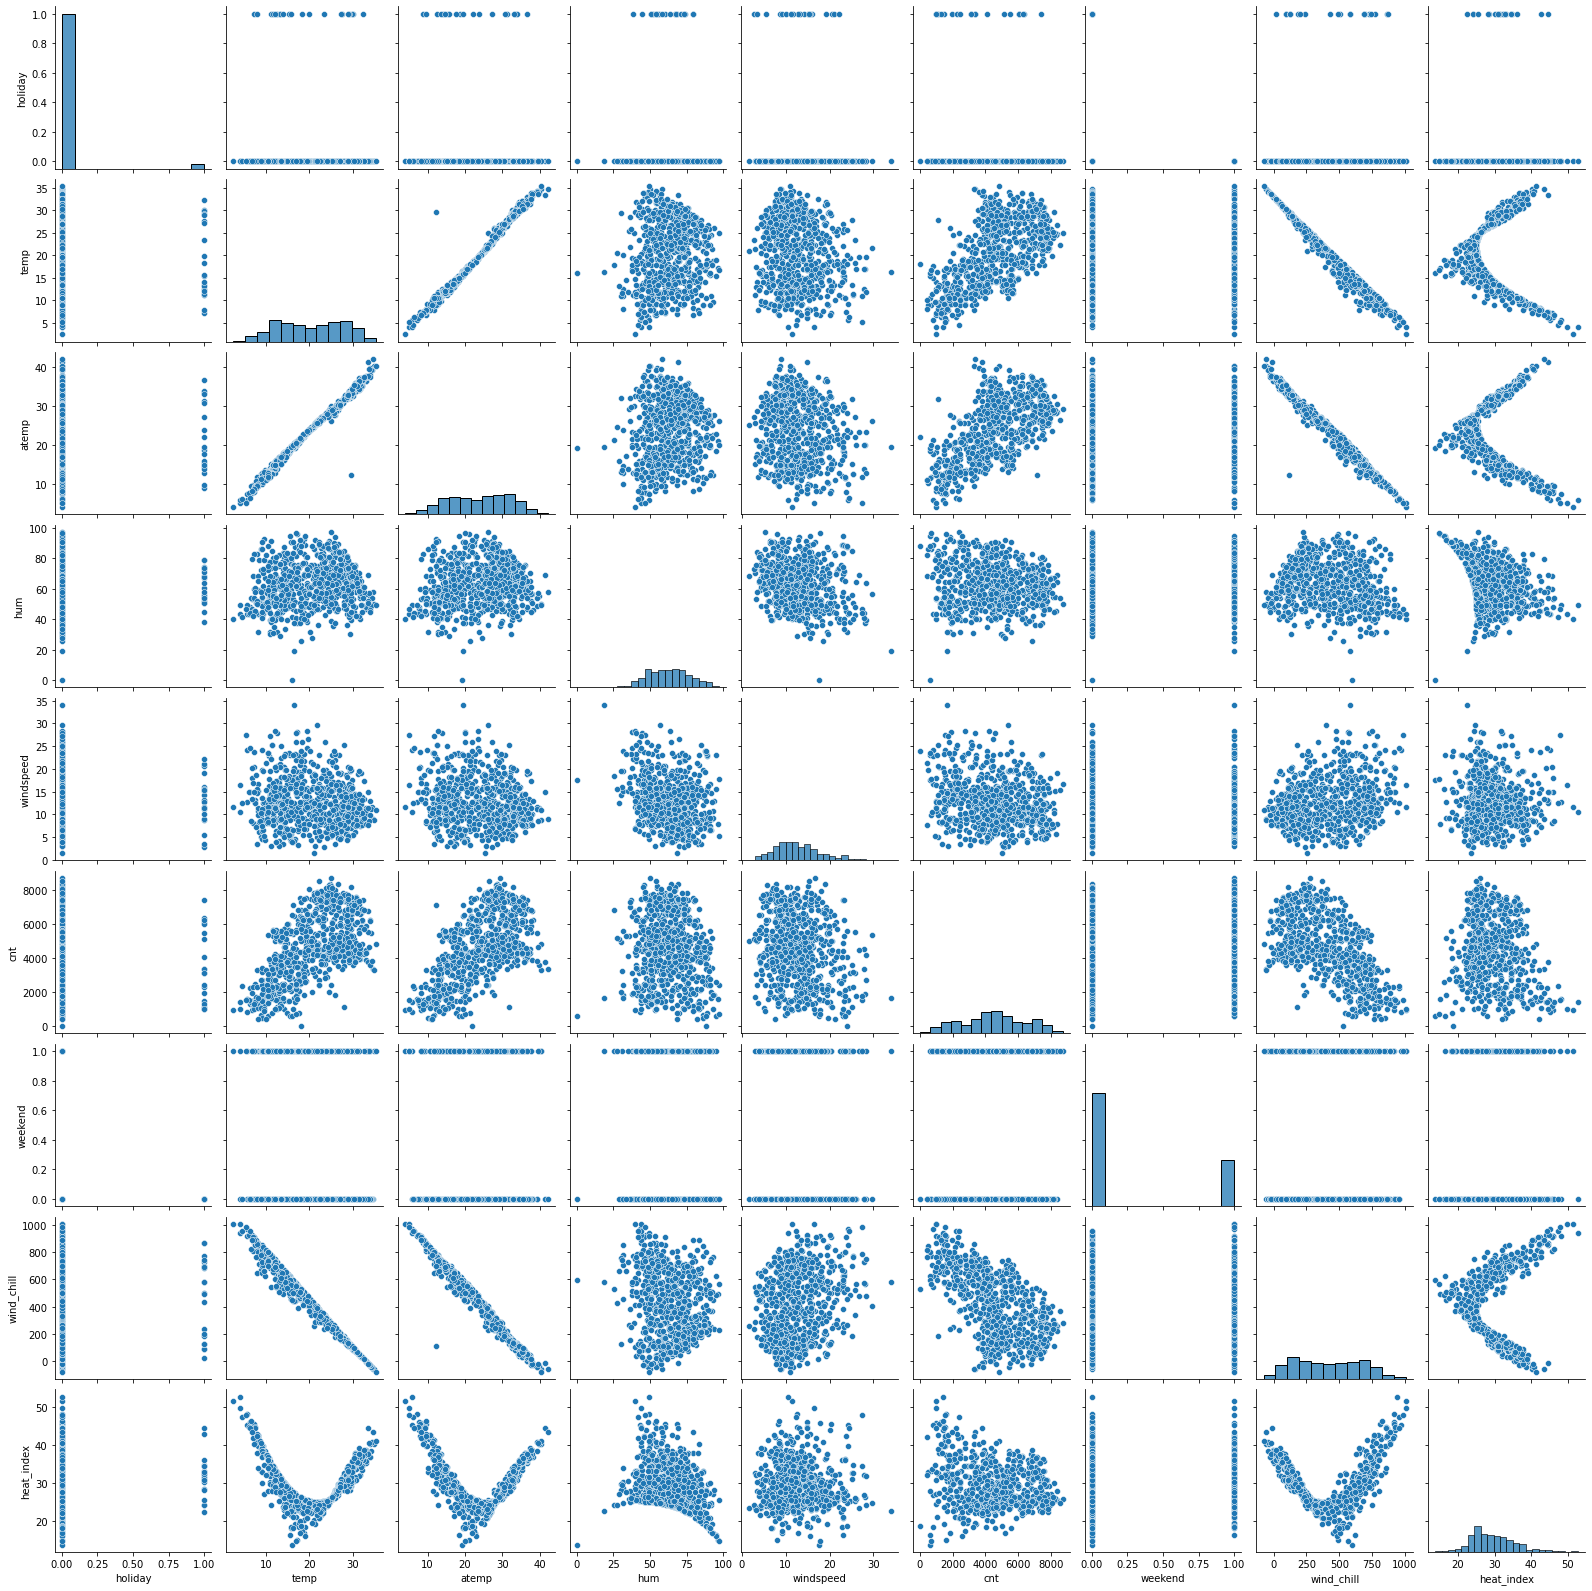

In [1866]:
# Pairwise plot for all numerical variables

sns.pairplot(day)
plt.show()

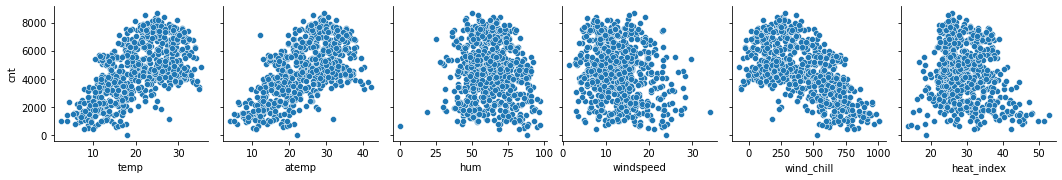

In [1867]:
# Visualizing parwise scatterplot for numerical variables against cnt

sns.pairplot(day, x_vars=['temp', 
                          'atemp', 
                          'hum', 
                          'windspeed', 
                          'wind_chill', 
                          'heat_index'], 
             y_vars='cnt')
plt.show()

In [1868]:
# Creating dummy variables
seasons_df=pd.get_dummies(day['season'], drop_first=True)
weathersit_df=pd.get_dummies(day['weathersit'], drop_first=True)
mnths_df=pd.get_dummies(day['mnth'], drop_first=True)

In [1869]:
# Concatenate the dummy variables to original dataframe
day=pd.concat([day, seasons_df, weathersit_df,mnths_df], axis=1)

In [1870]:
# Drop the columns weathersit and season
day.drop(['weathersit', 'season', 'mnth'], axis=1, inplace=True)
day.head()

,yr,holiday,temp,atemp,hum,windspeed,cnt,weekend,wind_chill,heat_index,...,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,2018,0,14.110847,18.18125,80.5833,10.749882,985,1,614.598839,24.476362,...,0,0,1,0,0,0,0,0,0,0
1,2018,0,14.902598,17.68695,69.6087,16.652113,801,1,627.163433,26.842729,...,0,0,1,0,0,0,0,0,0,0
2,2018,0,8.050924,9.47025,43.7273,16.636703,1349,0,864.520704,39.796654,...,0,0,1,0,0,0,0,0,0,0
3,2018,0,8.200000,10.60610,59.0435,10.739832,1562,0,806.789902,42.354356,...,0,0,1,0,0,0,0,0,0,0
4,2018,0,9.305237,11.46350,43.6957,12.522300,1600,0,790.565388,37.222610,...,0,0,1,0,0,0,0,0,0,0


In [1871]:
# Revert the yr labels
day['yr'].replace({
    '2018': 0,
    '2019': 1
}, inplace=True)

In [1872]:
day.head()

,yr,holiday,temp,atemp,hum,windspeed,cnt,weekend,wind_chill,heat_index,...,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,0,0,14.110847,18.18125,80.5833,10.749882,985,1,614.598839,24.476362,...,0,0,1,0,0,0,0,0,0,0
1,0,0,14.902598,17.68695,69.6087,16.652113,801,1,627.163433,26.842729,...,0,0,1,0,0,0,0,0,0,0
2,0,0,8.050924,9.47025,43.7273,16.636703,1349,0,864.520704,39.796654,...,0,0,1,0,0,0,0,0,0,0
3,0,0,8.200000,10.60610,59.0435,10.739832,1562,0,806.789902,42.354356,...,0,0,1,0,0,0,0,0,0,0
4,0,0,9.305237,11.46350,43.6957,12.522300,1600,0,790.565388,37.222610,...,0,0,1,0,0,0,0,0,0,0


In [1873]:
# Spliting the train and test data with a ratio of 7:3

day_train, day_test = train_test_split(day, train_size=0.70, test_size=0.30, random_state=100)
print (day_train.shape)
print (day_test.shape)

(510, 26)
(219, 26)


In [1874]:
# 1. Instantiate an object
scaler = MinMaxScaler()

# create a list of numeric vars
num_vars = ['temp', 'atemp', 'hum', 'windspeed', 'wind_chill', 'heat_index', 'cnt']

# 2. Fit on data
day_train[num_vars] = scaler.fit_transform(day_train[num_vars])
day_train.head()

,yr,holiday,temp,atemp,hum,windspeed,cnt,weekend,wind_chill,heat_index,...,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
653,1,0,0.509887,0.501133,0.575354,0.300794,0.864243,0,0.493764,0.293021,...,0,0,0,0,0,0,0,0,1,0
576,1,0,0.815169,0.766351,0.725633,0.264686,0.827658,0,0.183605,0.503635,...,0,0,0,1,0,0,0,0,0,0
426,1,0,0.442393,0.438975,0.640189,0.255342,0.465255,1,0.551976,0.313136,...,0,0,0,0,0,1,0,0,0,0
728,1,0,0.245101,0.200348,0.498067,0.663106,0.204096,1,0.807873,0.570700,...,1,0,0,0,0,0,0,0,0,0
482,1,0,0.395666,0.391735,0.504508,0.188475,0.482973,1,0.577818,0.377168,...,0,0,0,0,0,0,0,0,0,0


In [1875]:
day_train.describe()

,yr,holiday,temp,atemp,hum,windspeed,cnt,weekend,wind_chill,heat_index,...,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,...,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.507843,0.025490,0.537262,0.512989,0.650369,0.320768,0.513620,0.298039,0.461767,0.403329,...,0.084314,0.066667,0.088235,0.076471,0.074510,0.098039,0.084314,0.086275,0.086275,0.080392
std,0.500429,0.157763,0.225844,0.212385,0.145882,0.169797,0.224593,0.457846,0.229947,0.154847,...,0.278131,0.249689,0.283915,0.266010,0.262857,0.297660,0.278131,0.281045,0.281045,0.272166
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.339853,0.332086,0.538643,0.199179,0.356420,0.000000,0.259726,0.289184,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.540519,0.526811,0.653714,0.296763,0.518638,0.000000,0.459853,0.377902,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.735215,0.688457,0.754830,0.414447,0.684710,1.000000,0.650382,0.499506,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


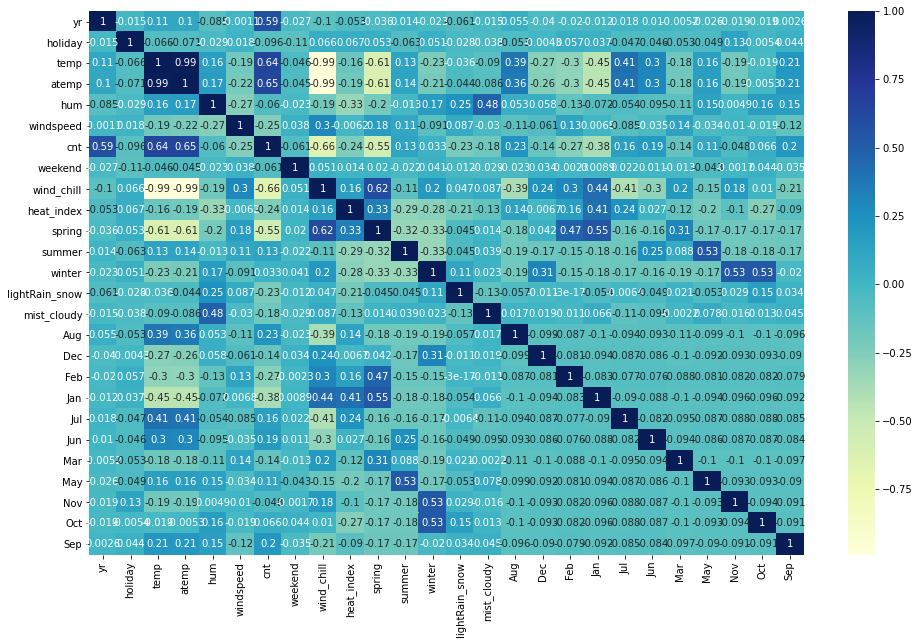

In [1876]:
# Plotting the correlation 

plt.figure(figsize=(16,10))
sns.heatmap(day_train.corr(), annot=True, cmap='YlGnBu')
plt.show()

In [1877]:
day_train.columns

Index(['yr', 'holiday', 'temp', 'atemp', 'hum', 'windspeed', 'cnt', 'weekend',
       'wind_chill', 'heat_index', 'spring', 'summer', 'winter',
       'lightRain_snow', 'mist_cloudy', 'Aug', 'Dec', 'Feb', 'Jan', 'Jul',
       'Jun', 'Mar', 'May', 'Nov', 'Oct', 'Sep'],
      dtype='object')

In [1878]:
# X_train, y_train
y_train = day_train.pop('cnt')
X_train = day_train

In [1879]:
# Create LinearRegression() object
lm = LinearRegression()

# Fit the train model
lm.fit(X_train, y_train)

# Using RFE, selecting 15 features
rfe = RFE(lm, 15)
rfe = rfe.fit(X_train, y_train)

In [1880]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('temp', True, 1),
 ('atemp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('weekend', False, 8),
 ('wind_chill', True, 1),
 ('heat_index', True, 1),
 ('spring', True, 1),
 ('summer', False, 7),
 ('winter', True, 1),
 ('lightRain_snow', True, 1),
 ('mist_cloudy', True, 1),
 ('Aug', True, 1),
 ('Dec', False, 3),
 ('Feb', False, 6),
 ('Jan', False, 5),
 ('Jul', False, 9),
 ('Jun', False, 4),
 ('Mar', False, 11),
 ('May', True, 1),
 ('Nov', False, 2),
 ('Oct', False, 10),
 ('Sep', True, 1)]

In [1881]:
# Fetching the list of columns selected by RFE

col = X_train.columns[rfe.support_]
col

Index(['yr', 'holiday', 'temp', 'atemp', 'hum', 'windspeed', 'wind_chill',
       'heat_index', 'spring', 'winter', 'lightRain_snow', 'mist_cloudy',
       'Aug', 'May', 'Sep'],
      dtype='object')

## Model 1 - Using all the features selected in RFE

In [1882]:
# add a constant
X_train_sm = X_train[col]
X_train_sm = sm.add_constant(X_train_sm)

# create first model
lr = sm.OLS(y_train, X_train_sm)

# fit the model
lr_model = lr.fit()

# params
lr_model.params

const             0.248339
yr                0.227464
holiday          -0.083929
temp              0.702031
atemp            -0.041991
hum              -0.205279
windspeed        -0.225913
wind_chill        0.254532
heat_index       -0.224266
spring           -0.089605
winter            0.053250
lightRain_snow   -0.271766
mist_cloudy      -0.060191
Aug               0.029984
May               0.034465
Sep               0.081438
dtype: float64

In [1883]:
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     189.1
Date:                Tue, 11 Jan 2022   Prob (F-statistic):          1.39e-193
Time:                        20:14:03   Log-Likelihood:                 525.18
No. Observations:                 510   AIC:                            -1018.
Df Residuals:                     494   BIC:                            -950.6
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.2483      0.215      1.155      0.248      -0.174       0.671
yr                 0.2275      0.008     28.705      0.000       0.212       0.243
holiday           -0.0839      0.025     -3.366      0.001      -0.133      -0.035
temp               0.7020      0.239      2.933      0.004       0.232       1.172
atemp             -0.0420      0.138     -0.305      0.761      -0.313       0.229
hum               -0.2053      0.038     -5.445      0.000      -0.279      -0.131
windspeed         -0.2259      0.042     -5.370      0.000      -0.309      -0.143
wind_chill         0.2545      0.223      1.143      0.254      -0.183       0.692
heat_index        -0.2243      0.031     -7.334      0.000      -0.284      -0.164
spring            -0.0896      0.015     -5.982      0.000      -0.119      -0.060
winter             0.0533      0.013      4.099      0.000       0.028       0.079
lightRain_snow    -0.2718      0.026    -10.383      0.000      -0.323      -0.220
mist_cloudy       -0.0602      0.010     -5.838      0.000      -0.080      -0.040
Aug                0.0300      0.016      1.921      0.055      -0.001       0.061
May                0.0345      0.016      2.167      0.031       0.003       0.066
Sep                0.0814      0.016      5.254      0.000       0.051       0.112
==============================================================================
Omnibus:                       67.261   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              177.928
Skew:                          -0.658   Prob(JB):                     2.31e-39
Kurtosis:                       5.577   Cond. No.                         168.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1884]:
vif = pd.DataFrame()
X=X_train_sm
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,3056.91
3,temp,192.94
7,wind_chill,173.30
4,atemp,56.47
6,windspeed,3.37
9,spring,2.73
10,winter,2.09
5,hum,2.00
12,mist_cloudy,1.59
8,heat_index,1.48


## Model 2 - Removing `atemp` variable

In [1885]:
# add a constant
X_train_sm = X_train_sm.drop('atemp', axis=1)
X_train_sm = sm.add_constant(X_train_sm)

# create first model
lr = sm.OLS(y_train, X_train_sm)

# fit the model
lr_model = lr.fit()

# params
lr_model.params

const             0.237247
yr                0.227514
holiday          -0.083682
temp              0.672756
hum              -0.205502
windspeed        -0.225853
wind_chill        0.264506
heat_index       -0.222643
spring           -0.089643
winter            0.053202
lightRain_snow   -0.271022
mist_cloudy      -0.060127
Aug               0.030697
May               0.034532
Sep               0.081652
dtype: float64

In [1886]:
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     203.0
Date:                Tue, 11 Jan 2022   Prob (F-statistic):          1.00e-194
Time:                        20:14:03   Log-Likelihood:                 525.14
No. Observations:                 510   AIC:                            -1020.
Df Residuals:                     495   BIC:                            -956.8
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.2372      0.212      1.121      0.263      -0.179       0.653
yr                 0.2275      0.008     28.743      0.000       0.212       0.243
holiday           -0.0837      0.025     -3.361      0.001      -0.133      -0.035
temp               0.6728      0.219      3.071      0.002       0.242       1.103
hum               -0.2055      0.038     -5.457      0.000      -0.279      -0.132
windspeed         -0.2259      0.042     -5.374      0.000      -0.308      -0.143
wind_chill         0.2645      0.220      1.201      0.230      -0.168       0.697
heat_index        -0.2226      0.030     -7.401      0.000      -0.282      -0.164
spring            -0.0896      0.015     -5.990      0.000      -0.119      -0.060
winter             0.0532      0.013      4.099      0.000       0.028       0.079
lightRain_snow    -0.2710      0.026    -10.409      0.000      -0.322      -0.220
mist_cloudy       -0.0601      0.010     -5.839      0.000      -0.080      -0.040
Aug                0.0307      0.015      1.991      0.047       0.000       0.061
May                0.0345      0.016      2.173      0.030       0.003       0.066
Sep                0.0817      0.015      5.278      0.000       0.051       0.112
==============================================================================
Omnibus:                       67.683   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              178.874
Skew:                          -0.662   Prob(JB):                     1.44e-39
Kurtosis:                       5.582   Cond. No.                         161.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1887]:
vif = pd.DataFrame()
X=X_train_sm
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,2969.38
6,wind_chill,169.57
3,temp,161.90
5,windspeed,3.37
8,spring,2.73
9,winter,2.09
4,hum,2.00
11,mist_cloudy,1.58
7,heat_index,1.44
12,Aug,1.37


## Model 3 - Removing `wind_chill` variable

In [1888]:
# add a constant
X_train_sm = X_train_sm.drop('wind_chill', axis=1)
X_train_sm = sm.add_constant(X_train_sm)

# create first model
lr = sm.OLS(y_train, X_train_sm)

# fit the model
lr_model = lr.fit()

# params
lr_model.params

const             0.487816
yr                0.227550
holiday          -0.083636
temp              0.411924
hum              -0.209775
windspeed        -0.185265
heat_index       -0.219831
spring           -0.089397
winter            0.051435
lightRain_snow   -0.267724
mist_cloudy      -0.058803
Aug               0.030869
May               0.034943
Sep               0.082774
dtype: float64

In [1889]:
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     218.3
Date:                Tue, 11 Jan 2022   Prob (F-statistic):          1.36e-195
Time:                        20:14:03   Log-Likelihood:                 524.39
No. Observations:                 510   AIC:                            -1021.
Df Residuals:                     496   BIC:                            -961.5
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.4878      0.036     13.550      0.000       0.417       0.559
yr                 0.2276      0.008     28.735      0.000       0.212       0.243
holiday           -0.0836      0.025     -3.358      0.001      -0.133      -0.035
temp               0.4119      0.029     14.186      0.000       0.355       0.469
hum               -0.2098      0.038     -5.593      0.000      -0.283      -0.136
windspeed         -0.1853      0.025     -7.406      0.000      -0.234      -0.136
heat_index        -0.2198      0.030     -7.326      0.000      -0.279      -0.161
spring            -0.0894      0.015     -5.971      0.000      -0.119      -0.060
winter             0.0514      0.013      3.987      0.000       0.026       0.077
lightRain_snow    -0.2677      0.026    -10.335      0.000      -0.319      -0.217
mist_cloudy       -0.0588      0.010     -5.741      0.000      -0.079      -0.039
Aug                0.0309      0.015      2.001      0.046       0.001       0.061
May                0.0349      0.016      2.199      0.028       0.004       0.066
Sep                0.0828      0.015      5.358      0.000       0.052       0.113
==============================================================================
Omnibus:                       68.089   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              181.231
Skew:                          -0.664   Prob(JB):                     4.43e-40
Kurtosis:                       5.601   Cond. No.                         21.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1890]:
vif = pd.DataFrame()
X=X_train_sm
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,85.84
3,temp,2.84
7,spring,2.73
8,winter,2.06
4,hum,1.98
10,mist_cloudy,1.57
6,heat_index,1.43
11,Aug,1.37
12,May,1.29
9,lightRain_snow,1.27


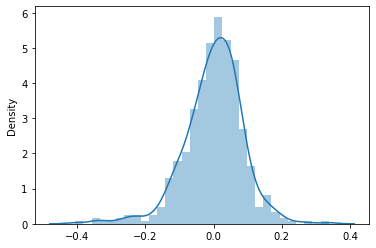

In [1891]:
# Calculate predicted values
y_train_pred=lr_model.predict(X_train_sm)

# Calculate residuals
res = y_train - y_train_pred

# Plotting the residuals to verifyif it is normal distribution
sns.distplot(res)
plt.show()

### Plotting `y_train` and `y_train_pred`

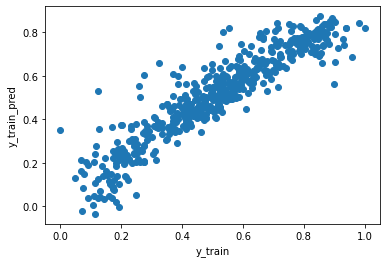

In [1892]:
plt.scatter(y_train, y_train_pred)
plt.xlabel('y_train')
plt.ylabel('y_train_pred')
plt.show()

## Model Evaluation using Test data

In [1893]:
# Numerical variables
num_vars = ['temp', 'atemp', 'hum', 'windspeed', 'wind_chill', 'heat_index', 'cnt']

# 2. Fit on data
day_test[num_vars] = scaler.transform(day_test[num_vars])
day_test.head()

,yr,holiday,temp,atemp,hum,windspeed,cnt,weekend,wind_chill,heat_index,...,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
184,0,1,0.831783,0.769660,0.657364,0.084219,0.692706,0,0.154343,0.499348,...,0,0,0,1,0,0,0,0,0,0
535,1,0,0.901354,0.842587,0.610133,0.153728,0.712034,0,0.096047,0.598081,...,0,0,0,0,1,0,0,0,0,0
299,0,0,0.511964,0.496145,0.837699,0.334206,0.303382,0,0.496970,0.178561,...,0,0,0,0,0,0,0,0,1,0
221,0,0,0.881625,0.795343,0.437098,0.339570,0.547400,0,0.118993,0.465759,...,0,0,0,0,0,0,0,0,0,0
152,0,0,0.817246,0.741471,0.314298,0.537414,0.569029,0,0.189918,0.370137,...,0,0,0,0,1,0,0,0,0,0


In [1894]:
# Dependent variable is cnt
y_test=day_test.pop('cnt')

X_test=day_test

In [1895]:
X_train_sm.drop('const', axis=1, inplace=True)

In [1896]:
# add a constant
X_test_sm = X_test[X_train_sm.columns]
X_test_sm = sm.add_constant(X_test_sm)

In [1897]:
# predict the values
y_test_pred = lr_model.predict(X_test_sm)

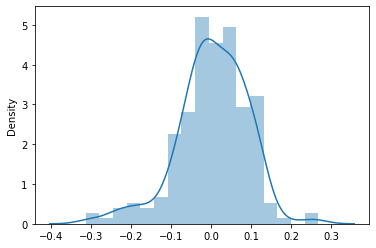

In [1898]:
# Calculate residuals on test data and verify normal distribution
res=y_test-y_test_pred
sns.distplot(res)
plt.show()

In [1899]:
# Calculate R2 value for test data
r2_score(y_true=y_test, y_pred=y_test_pred)

0.83905734296284

In [1900]:
# Calculate R2 value for train data
r2_score(y_true=y_train, y_pred=y_train_pred)

0.8512404827184036

### Plotting `y_test` and `y_test_pred`

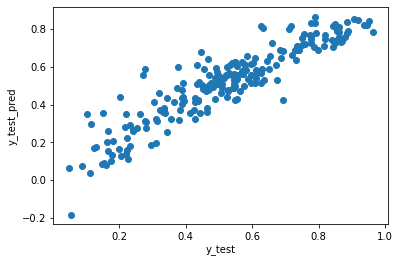

In [1901]:
plt.scatter(y_test, y_test_pred)
plt.xlabel('y_test')
plt.ylabel('y_test_pred')
plt.show()

**The final model:**

$cnt = 0.4878 + 0.2276*yr - 0.0836 * holiday + 0.4119 * temp - 0.2098 * hum - 0.1853 * wind\_speed - 0.2198 * heat\_index - 0.0894 * spring + 0.0514 * winter - 0.2677 * lightRain\_snow - 0.0588 * mist\_cloudy + 0.0309 * Aug + 0.0349 * May + 0.0828 * Sep$